<a href="https://colab.research.google.com/github/borisenko-ru/ds_projects/blob/main/04_Gas_Production_Forecasting/Diploma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Моделирование дебита газовых скважин с применением машинного обучения на основе данных добычи в Северном море



In [53]:
import pandas as pd
import numpy as np
import seaborn as sns

from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
from datetime import timedelta
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
from xgboost import XGBRegressor


In [54]:
!pip install statsmodels
!pip install fbprophet

In [55]:
class Plots():
  """Класс для отрисовки графиков, используемых в проекте.
  """
  
  def wells(data):
    """Функция для построения графиков добычи из скважин.
    """

    for well in wells:
      data_well = data[data['WELLNAME'] == well].reset_index()
      data_well.plot('DAYTIME', 'ALLOC_GAS_VOL_SM3', kind = 'scatter', s=0.1, title = well)
      plt.show()

  def forecast_plot(actual, forecast, predict_period):
    """Функция для построения графика истинных и прогнозных значений.
    """
  
    predict_start = forecast.index[-predict_period]
    predict_end = forecast.index[-1]

    plt.figure(figsize=(12, 4))
    plt.plot(forecast, color='navy', label='forecast', linewidth=1)
    plt.plot(actual, color='forestgreen', label='actual', linewidth=1)
    plt.legend()
    plt.axvspan(predict_start, predict_end, alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.xlim(pd.Timestamp(forecast.index[0].year, 1, 1), pd.Timestamp(forecast.index[-1].year+1, 1, 1))

  def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """Функция для построения графиков анализа временных рядов.
    """
    
    if not isinstance(y, pd.Series):
      y = pd.Series(y)
    with plt.style.context(style):    
      fig = plt.figure(figsize=figsize)
      layout = (2, 2)
      ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
      acf_ax = plt.subplot2grid(layout, (1, 0))
      pacf_ax = plt.subplot2grid(layout, (1, 1))
      acf_ax.set_xlabel('Lag (days)')
      pacf_ax.set_xlabel('Lag (days)')
      
      y.plot(ax=ts_ax)
      ts_ax.set_title('Time Series Analysis Plots')
      smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
      smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

      print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

      plt.tight_layout()
    return

  def seasonal_decomposition(data):
    """Функция для построения графиков декомпозиции.
    """
    
    decomposed = seasonal_decompose(data) 
    plt.figure(figsize=(6, 8))
    plt.subplot(311)

    # Чтобы график корректно отобразился, указываем его
    # оси ax, равными plt.gca() (англ. get current axis,
    # получить текущие оси)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

  def boxplot(data, error):
    """Функция для оценки ошибок МАЕ и MAPE применительно к временным рядам 
    воспользуемся методикой, изложенной в статье (Jiang и Hu, 2018), 
    выделив распределение ошибки по месяцам года с помощью диаграммы 
    разброса.
    """
    
    years = data.index.year.unique().tolist()
    months = range(1, 13)
    
    error_per_year = pd.DataFrame(index=months)
    for year in years:
      error_per_month = {}
      for month in months:
        data_error = data[
                          (data.index.year == year) & 
                          (data.index.month == month) &
                          (data['actual'] != 0) & 
                          (data['forecast'] != 0)
                          ]
        if data_error.shape[0] != 0:
          error_per_month[month] = round(error(data_error['actual'], data_error['forecast']), 1)
        else:
          error_per_month[month] = np.nan
          pass
   
      error_per_year[year] = pd.DataFrame.from_dict(error_per_month, orient='index', columns=[year])

    error_per_year.plot(kind='box', figsize=(12, 4), logy=True, ylabel='Monthly error, %')
    error_mean = round(error_per_year.median().mean(), 2)
    print('Среднее значение ежемесячной ошибки по годам: {}'.format(error_mean))
    pd.Series({1: error_mean, len(error_per_year.columns): error_mean}).plot.line(linestyle='--', color='r')

  def results():
    """Функция для построения графиков результатов анализа временных рядов.
    """

    plt.figure(figsize=(12, 6))
    plt.plot(df_fc_arima['actual'], 'D', label='Actual', markersize=3)
    plt.plot(df_fc_arima['forecast'], color='navy', label='SARIMA', linewidth=0.7)
    plt.plot(df_fc_prophet['forecast'], color='brown', label='PROPHET', linewidth=0.7)
    plt.plot(df_fc_xgb['forecast'], color='forestgreen', label='XGB', linewidth=0.7)
    plt.axvspan(df_fc_arima['forecast'].index[-predict_period], df_fc_arima['forecast'].index[-1], alpha=0.5, color='lightgrey')
    plt.legend()
    plt.grid(True)
    

In [56]:
# Подготовка данных временного ряда под задачу обучения с учителем для модели XGBoost
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	
  # последовательность на вход (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	
  # последовательность на выход - прогноз (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	
  # Объединим колонки
	agg = pd.concat(cols, axis=1)
	
  # Исключим из датасета NaN значения
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 

In [57]:
# Загрузим датасет
url = 'https://dataogauthority.blob.core.windows.net/external/CoP_Field_Production_Data/By_Field/Data/VIKINGB_P33_CONOCO_PHILLIPS_CoP_DATA.zip'
file = ZipFile((BytesIO(urlopen(url).read())))
file_name = file.namelist()[0]
data = pd.read_excel(file.open(file_name), engine='openpyxl')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246789 entries, 0 to 246788
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   WELL_UWI             246789 non-null  object        
 1   FIELD                246789 non-null  object        
 2   WELLNAME             246789 non-null  object        
 3   DAYTIME              246789 non-null  datetime64[ns]
 4   ALLOC_GAS_VOL_SM3    204159 non-null  float64       
 5   ALLOC_H2O_VOL_M3     0 non-null       float64       
 6   ALLOC_OIL_VOL_SM3    0 non-null       float64       
 7   ALLOC_GAS_VOL_MMSCF  204159 non-null  float64       
 8   ALLOC_H2O_VOL_BBLS   0 non-null       float64       
 9   ALLOC_OIL_VOL_BBLS   0 non-null       float64       
 10  BHP_BARG             9187 non-null    float64       
 11  BHT_DEGC             9654 non-null    float64       
 12  BHP_PSIG             9187 non-null    float64       
 13  BHT_DEGF      

In [58]:
# Выведем список добывающих скважин
wells = data['WELLNAME'].unique()
wells


array(['49/17-B03', '49/17-B08', '49/17-B04A', '49/17-C01', '49/17-C02Z',
       '49/17-D01', '49/17-D02', '49/17-05Y', '49/17-H02', '49/16-E01',
       '49/16-E03', '49/17-G02', '49/17-G03', '49/17-H03', '49/16-E03A',
       '49/16-E04', '49/17-G04', '49/17-C03', '49/16-E05', '49/17-C04',
       '49/17-G05', '49/12a-K03', '49/12a-K01', '49/12a-K02', '49/17-12',
       '49/17-L02Z', '49/12a-K05'], dtype=object)

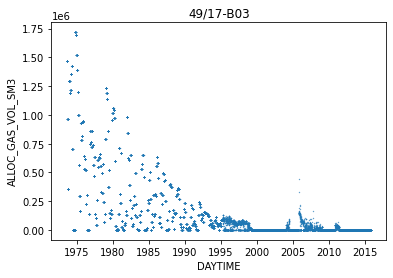

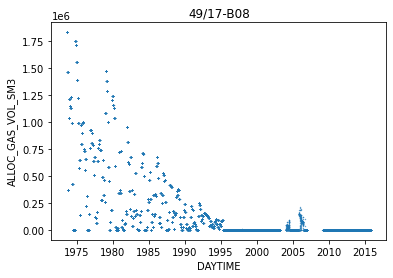

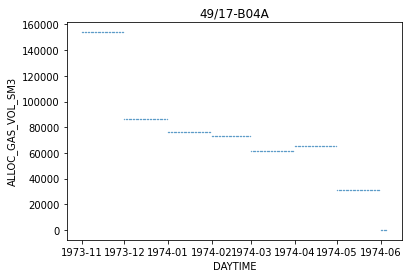

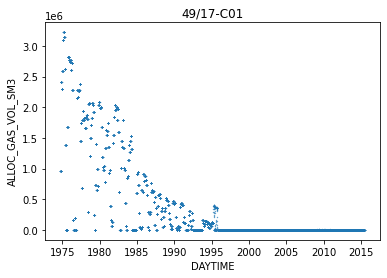

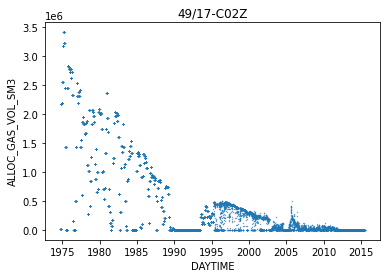

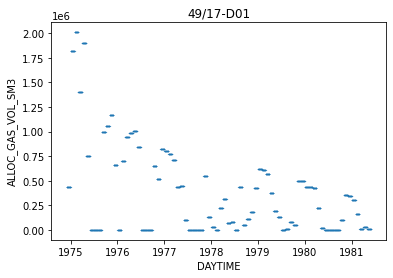

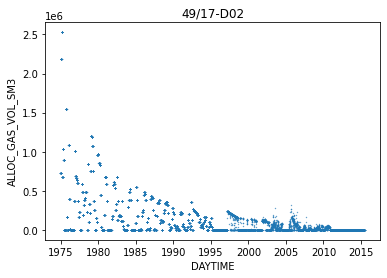

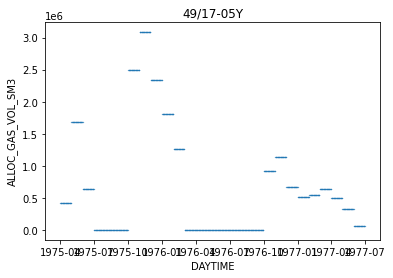

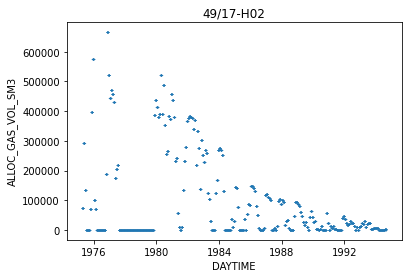

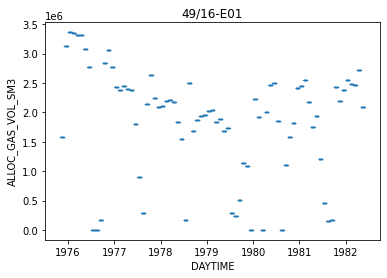

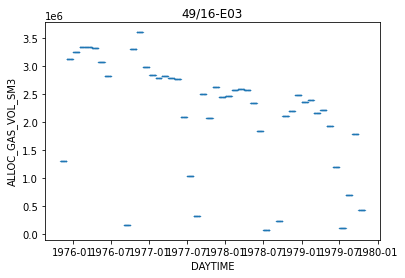

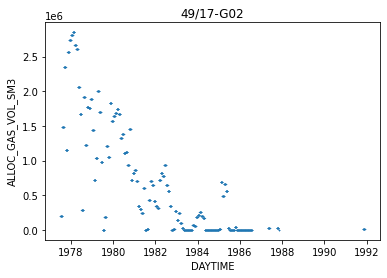

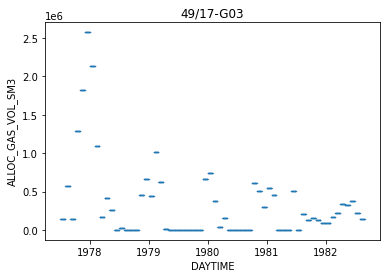

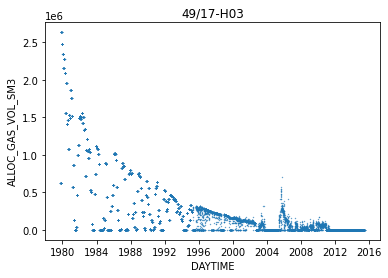

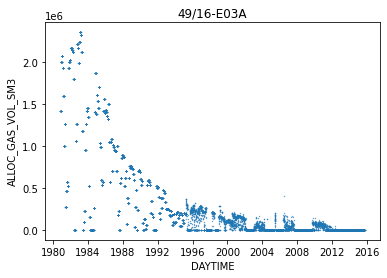

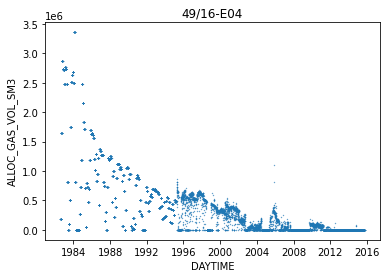

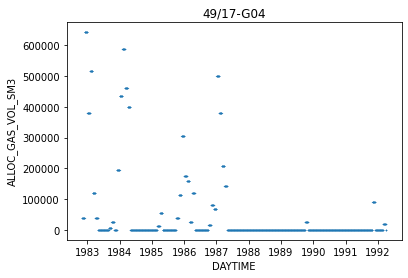

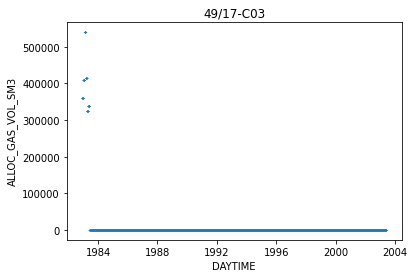

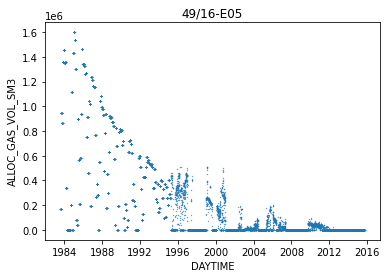

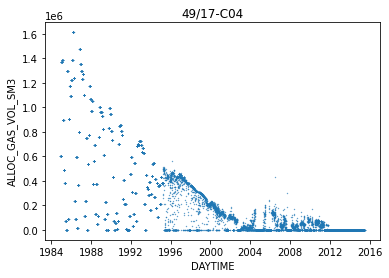

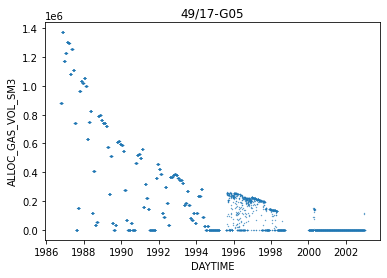

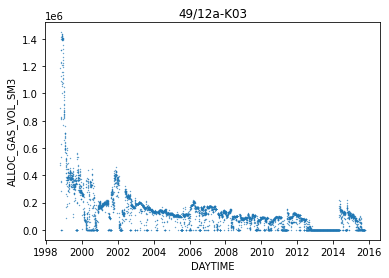

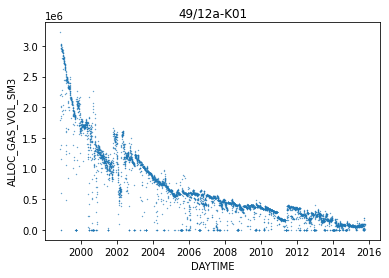

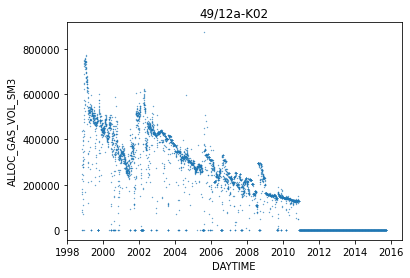

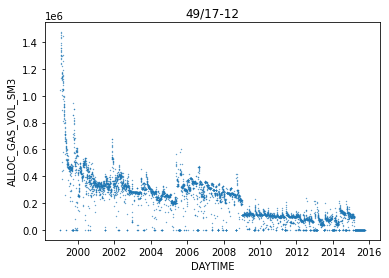

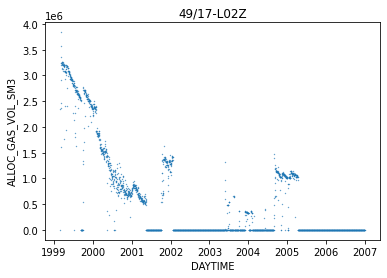

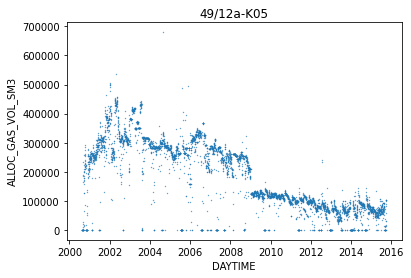

In [59]:
# Представим показатели добычи скважин на графиках
Plots.wells(data)


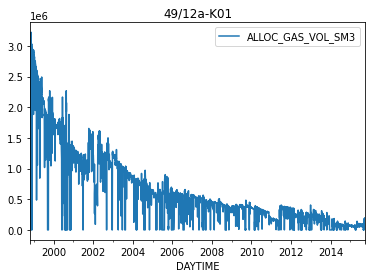

In [60]:
# Выберем конкретную скважину для прогноза дебита (добычи)
wellname = '49/12a-K01'
df = data[data['WELLNAME'] == wellname]

# Выделим ключевые признаки время и дебит
df = df[['DAYTIME', 'ALLOC_GAS_VOL_SM3']].set_index('DAYTIME')
df.plot(title = wellname)
plt.show()


Чтобы проверить, в хронологическом ли порядке расположены даты и время, используем атрибут индекса таблицы `is_monotonic`. Если порядок соблюдён, атрибут вернёт True, если нет — False. Также проверим количество пропусков и при необходимости заменим их нулевыми значениями, предположив, что в эти дни скважина была остановлена, например, для проведения технологических операций.


In [61]:
print(df.index.is_monotonic)
print('Количество пропущенных значений: ', df.isna().sum())
df = df.fillna(0)


True
Количество пропущенных значений:  ALLOC_GAS_VOL_SM3    12
dtype: int64


Из графика видно, что наш ряд имеет небольшое кол-во выбросов, которые влияют на разброс. Кроме того, анализировать дебит газа за каждый день не совсем верно, т.к., например, имеют место периодические остановки добычи для проведения различных технологических операций на скважине. Поэтому есть смысл перейти к недельному интервалу и среднему значению дебита на нем, это избавит нас от выбросов и уменьшит колебания нашего ряда. В pandas для этого есть удобная функция resample(), в качестве параметров ей передается период округления и аггрегатная функция.


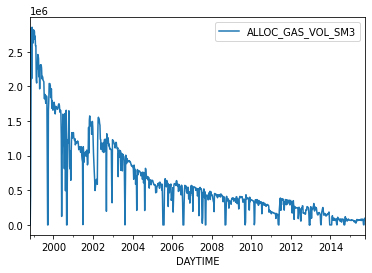

In [62]:
df = df.resample('W').mean()
df.plot(figsize=(6,4))
plt.show()


## SARIMA

При близком рассмотрении модели ARIMA (Autoregressive Integrated Moving Average) можно выделить три компонента, составляющих данный акроним (Fulton, 2017):
* *AR: Autoregression* - характеризует зависимость наблюдаемого значения от отстающих (предшествующих) значений
* *I: Integrated* - характеризует скорость изменения наблюдаемых значений путем вычитания текущего наблюдаемого значения из значения на предшествующем шаге, чтобы сделать временной ряд стационарным
* *MA: Moving Average* - характеризует зависимость между наблюдением и остаточной ошибкой из модели скользящего среднего, применяемой к предшествующим наблюдениям.

Общий вид модели ARIMA (с учетом сезонности):

$$SARIMA(p,d,q)(P,D,Q)_s$$

где $p$ — число отстающих значений ряда, включенных в модель (порядок авторегрессии) \
$d$ — количество раз, когда брали разность наблюдаемых и отстающих значений (степень разности) \
$q$ — число отстающих значений, которые прибавляются или вычитаются из наблюдаемого значения (порядок скользящего среднего) \
$P$ — порядок сезонной авторегрессии \
$D$ — степень сезонной разности \
$Q$ — порядок сезонного скользящего среднего \
$s$ — сезонность (в нашем случае при ежегодной сезонности с недельным интервалом это значение составит 52)


Построим первую прогнозную модель - SARIMA, предварительно приведем ряд к стационарному виду.


В модуле `tsa.seasonal` (от англ. time series analysis) библиотеки `statsmodels` есть функция `seasonal_decompose()` . Она раскладывает временной ряд на три составляющие: тренд, сезонность и остаток (англ. residuals). Это компонента, которая не объясняется трендом и сезонностью, это шум.


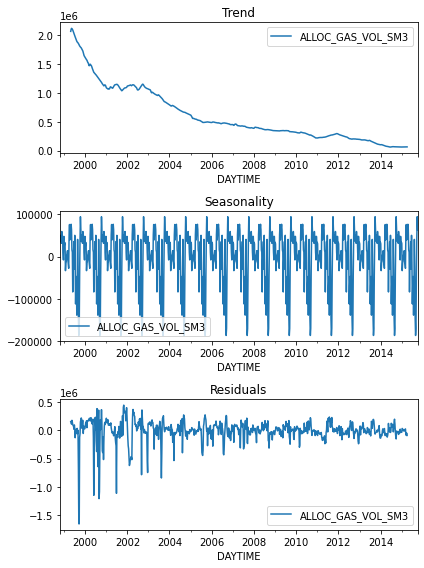

In [63]:
Plots.seasonal_decomposition(df)


Критерий Дики-Фуллера: p=0.003656


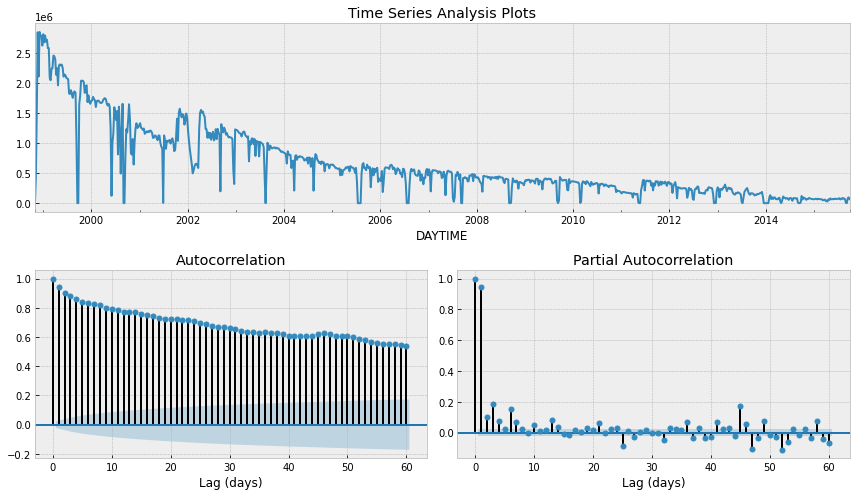

In [64]:
Plots.tsplot(df['ALLOC_GAS_VOL_SM3'], lags=60)


Критерий Дики-Фуллера отвергает нулевую гипотезу о нестационарности, но автокорреляционная функция показывает большое число значимых лагов. Так как на графике частной автокорреляционной функции значим лишь один лаг, возьмем первые разности, чтобы привести ряд к стационарному виду.


Критерий Дики-Фуллера: p=0.000000


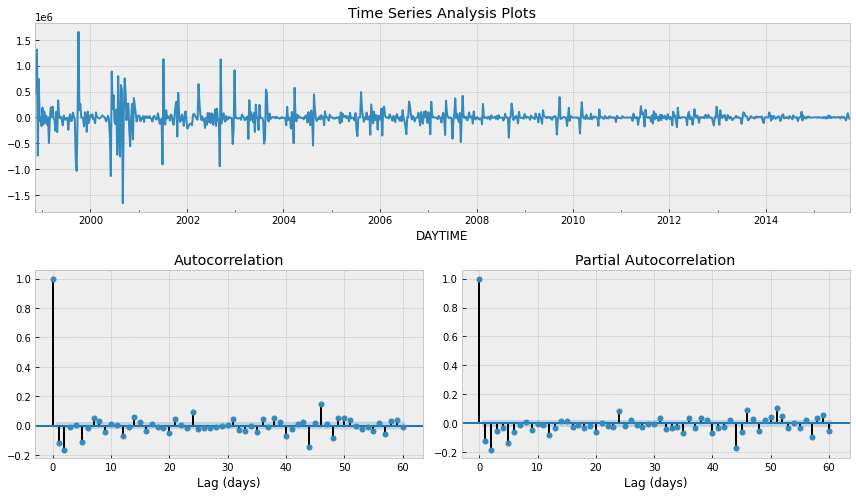

In [65]:
df['ALLOC_GAS_VOL_SM3_diff'] = df['ALLOC_GAS_VOL_SM3'] - df['ALLOC_GAS_VOL_SM3'].shift(1)
Plots.tsplot(df['ALLOC_GAS_VOL_SM3_diff'][1:], lags=60)


Получили стационарный ряд, по автокорреляционной и частной автокорреляционной функции подберем параметры для SARIMA модели.

Определим параметры $p, d, q$, после чего определим порядок сезонных составляющих $P,D,Q$.

Параметр *d* есть и он равет 1, осталось определить *p* и *q*. Для их определения нам надо изучить авторкорреляционную (*ACF*) и частную автокорреляционную (*PACF*) функции для ряда первых разностей.
*ACF* поможет нам определить *q*, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
*PACF* поможет нам определить *p*, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

После изучения коррелограммы *PACF* можно сделать вывод, что *p = 5*, т.к. на ней только 5 лаг сильно отличен от нуля. По коррелограмме *ACF* можно увидеть, что *q = 5*, т.к. после лага 5 значении функций резко падают.

Теперь перейдем к сезонным составляющим. В нашем случае, при сезонности 52, в лаге 52 параметры P и Q равны 0.
В результате наших исследований мы получили модель 

$$SARIMA(5,1,5)
(0,1,0)_{52}$$


In [66]:
# Возьмем прогнозный период за последние 2 года (104 недели)
predict_period = 104

# Выделим обучающую и тестовую выборки
df_train = df['ALLOC_GAS_VOL_SM3'][:-predict_period]
df_test = df['ALLOC_GAS_VOL_SM3'][-predict_period:]

model_arima = SARIMAX(df_train,
                      order=(5, 1, 5),
                      seasonal_order=(0, 1, 0, 52)).fit()

print(model_arima.summary())


                                 Statespace Model Results                                 
Dep. Variable:                  ALLOC_GAS_VOL_SM3   No. Observations:                  780
Model:             SARIMAX(5, 1, 5)x(0, 1, 0, 52)   Log Likelihood              -10097.452
Date:                            Tue, 14 Dec 2021   AIC                          20216.905
Time:                                    22:17:41   BIC                          20267.383
Sample:                                11-01-1998   HQIC                         20236.383
                                     - 10-06-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4925      0.151     -3.263      0.001      -0.788      -0.197
ar.L2         -1.0437      0.155   

Проверим остатки модели:

Критерий Дики-Фуллера: p=0.000000


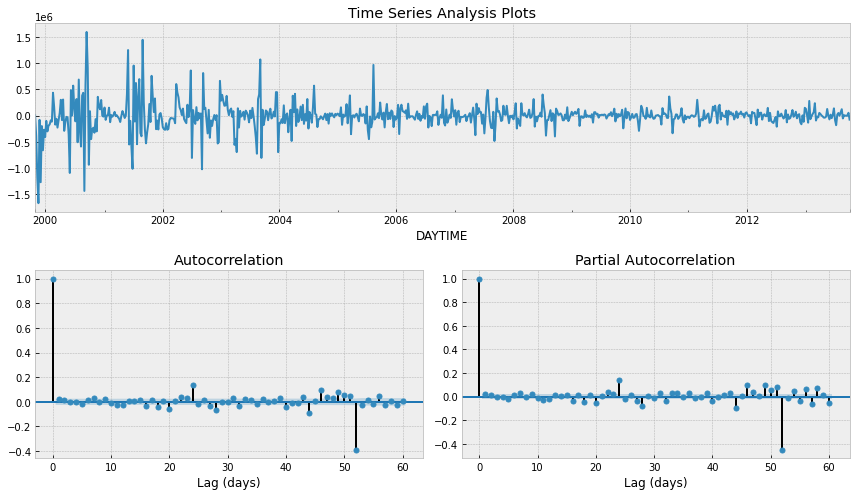

In [67]:
Plots.tsplot(model_arima.resid[52:], lags=60)


Остатки стационарны, явных автокорреляций нет, построим прогноз по получившейся модели.

Построим графики истинных и прогнозных значений, а также проведем оценку качества с помощью метрик MAE и MAPE.

(733773.0, 735964.0)

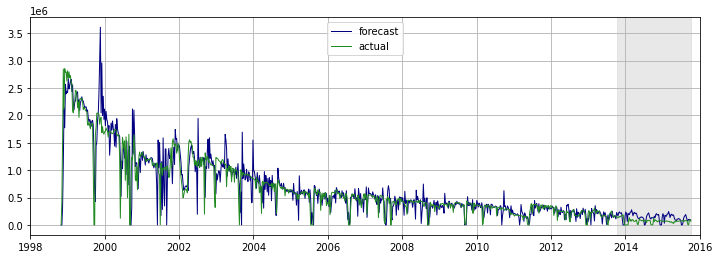

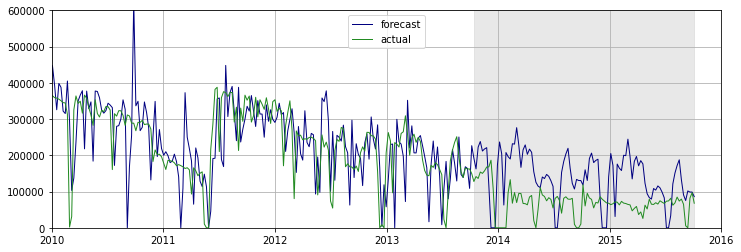

In [68]:
# Выделим истинные и прогнозные значения для графиков
actual = df['ALLOC_GAS_VOL_SM3']
forecast = model_arima.fittedvalues.append(model_arima.forecast(steps=predict_period))

# Дебит скважины не может быть отрицательным
# Заменим отрицательные прогнозные значения на 0
forecast[forecast <= 0] = 0

# Дополним исходный датафрейм прогнозными значениями
df_fc_arima = pd.concat([df['ALLOC_GAS_VOL_SM3'], forecast], axis=1, keys=['actual', 'forecast']).astype('float64')

# Построим график (полный)
Plots.forecast_plot(actual, forecast, predict_period)

# Построим график (по целевому участку)
Plots.forecast_plot(actual, forecast, predict_period)
plt.ylim(0, 6e05)
plt.xlim(pd.Timestamp(2010, 1, 1), pd.Timestamp(2016, 1, 1))


Среднее значение ежемесячной ошибки по годам: 159460.97


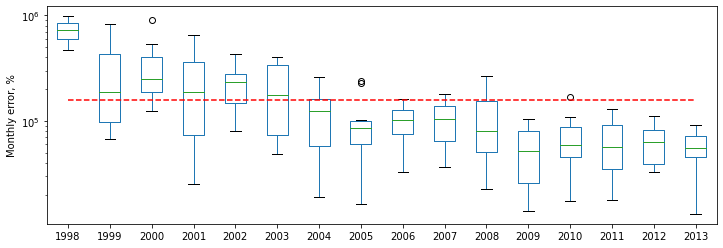

In [69]:
# Построим диаграммы размаха метрики MAE для обучающей выборки
Plots.boxplot(df_fc_arima[:-predict_period], mae)


Среднее значение ежемесячной ошибки по годам: 0.21


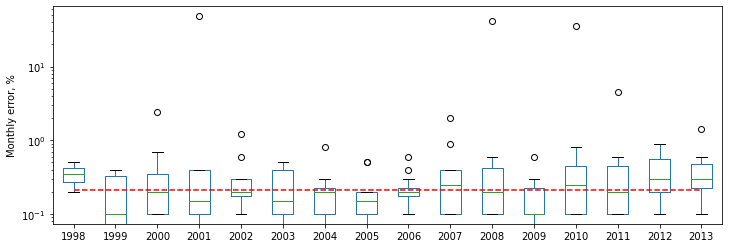

In [70]:
# Построим диаграммы размаха для метрики MAPE для обучающей выборки
Plots.boxplot(df_fc_arima[:-predict_period], mape)


Среднее значение ежемесячной ошибки по годам: 72585.07


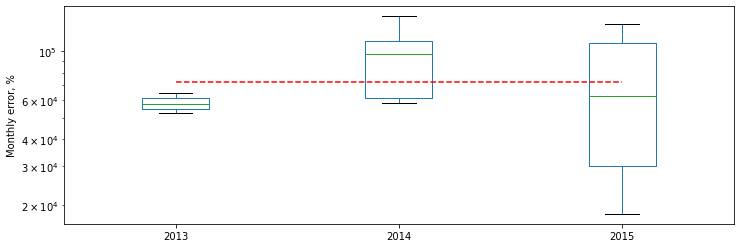

In [71]:
# Построим диаграммы размаха метрики MAE для тестовой выборки
Plots.boxplot(df_fc_arima[-predict_period:], mae)


Среднее значение ежемесячной ошибки по годам: 1.05


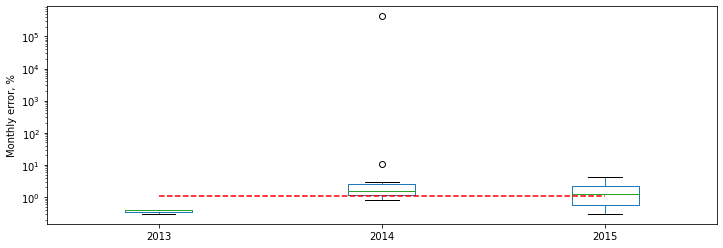

In [72]:
# Построим диаграммы размаха метрики MAPE для тестовой выборки
Plots.boxplot(df_fc_arima[-predict_period:], mape)


(734503.0, 736695.0)

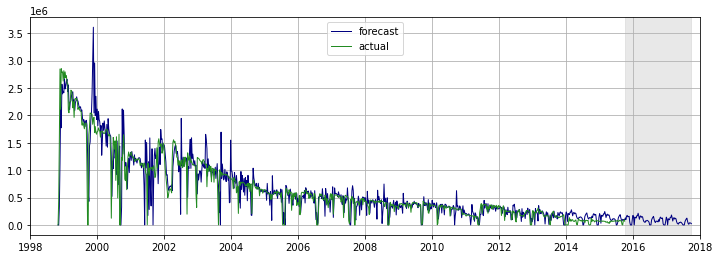

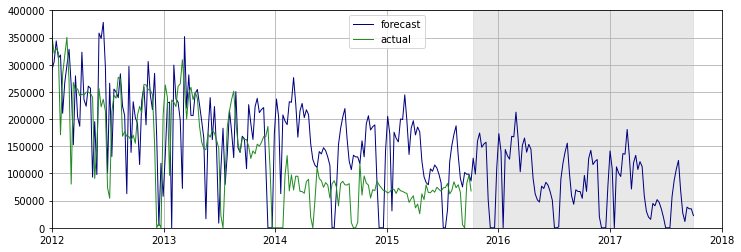

In [73]:
# Прогноз на следующие 2 года (вне исходных данных)
actual = df['ALLOC_GAS_VOL_SM3']
forecast = model_arima.fittedvalues.append(model_arima.forecast(steps=2*predict_period))
forecast[forecast <= 0] = 0

# Построим график (полный)
Plots.forecast_plot(actual, forecast, predict_period)

# Построим график (по целевому участку)
Plots.forecast_plot(actual, forecast, predict_period)
plt.ylim(0, 4e05)
plt.xlim(pd.Timestamp(2012, 1, 1), pd.Timestamp(2018, 1, 1))

### Facebook Prophet


In [74]:
#Создадим и обучим модель
model_prophet = Prophet()
model_prophet.fit(pd.DataFrame({'ds': df_train.index, 'y': df_train}).reset_index(drop=True))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [75]:
# Укажем период предсказания (2 года)
periods = 724
future = model_prophet.make_future_dataframe(periods=periods)
future.tail()


,ds
1499,2015-09-26
1500,2015-09-27
1501,2015-09-28
1502,2015-09-29
1503,2015-09-30


In [76]:
# Построим прогноз
prediction = model_prophet.predict(future)
prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1499,2015-09-26,-65408.940827,-354945.842422,256257.618154
1500,2015-09-27,-48392.242984,-379396.513621,259426.919178
1501,2015-09-28,-30342.438881,-368545.445109,265877.273840
1502,2015-09-29,-11532.985736,-323763.053091,313750.627326
1503,2015-09-30,7746.894673,-347240.412480,325567.029343


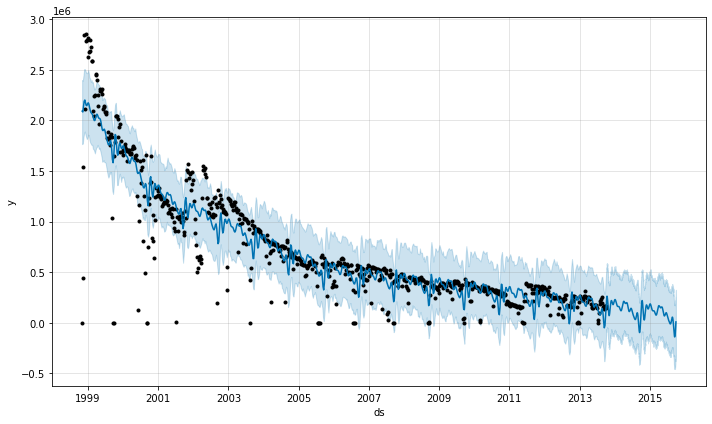

In [77]:
# Выведем график прогноза (встроенная функция)
fig1 = model_prophet.plot(prediction)


(733773.0, 735964.0)

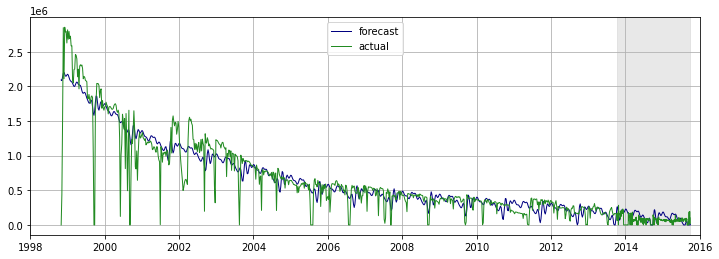

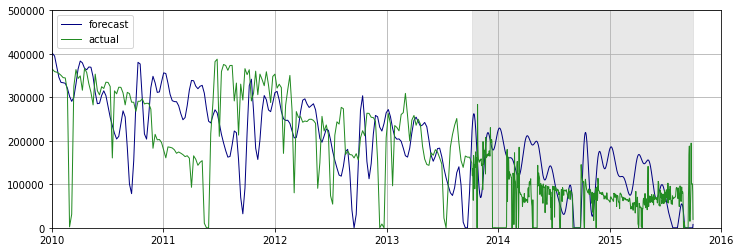

In [78]:
# Выделим истинные и прогнозные значения для графиков
actual_filtered = data[(data['WELLNAME'] == wellname) & 
     (data['DAYTIME'] >= '2013-10-07') & 
     (data['DAYTIME'] <= '2015-10-06')][['DAYTIME', 'ALLOC_GAS_VOL_SM3']].set_index('DAYTIME')

actual = pd.DataFrame(df_train).append(pd.DataFrame(actual_filtered))
forecast = prediction[['ds', 'yhat']].set_index('ds')
forecast[forecast <= 0] = 0

# Дополним исходный датафрейм прогнозными значениями
df_fc_prophet = pd.concat([actual, forecast], axis=1, ignore_index=True).astype('float64')
df_fc_prophet.rename(columns={0: 'actual', 1: 'forecast'}, inplace=True)

# Построим график (полный)
Plots.forecast_plot(actual, forecast, periods)

# Построим график (по целевому участку)
Plots.forecast_plot(actual, forecast, periods)
plt.ylim(0, 5e05)
plt.xlim(pd.Timestamp(2010, 1, 1), pd.Timestamp(2016, 1, 1))

Среднее значение ежемесячной ошибки по годам: 145771.83


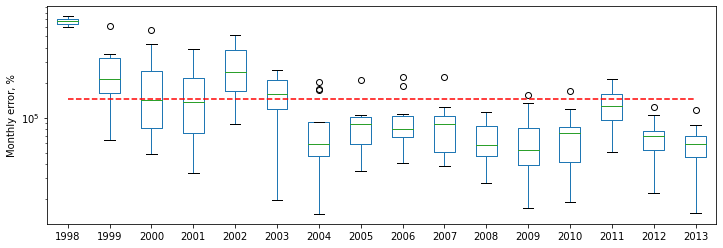

In [79]:
# Построим диаграммы размаха метрики MAE для обучающей выборки
Plots.boxplot(df_fc_prophet[:-periods], mae)


Среднее значение ежемесячной ошибки по годам: 0.23


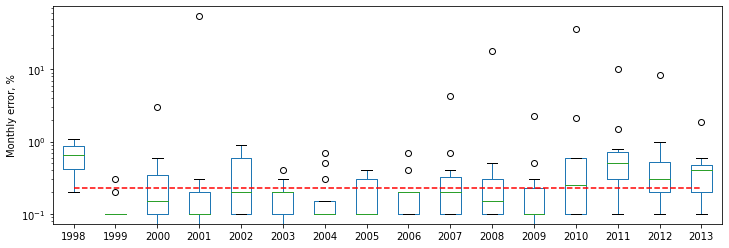

In [80]:
# Построим диаграммы размаха метрики MAPE для обучающей выборки
Plots.boxplot(df_fc_prophet[:-periods], mape)


Среднее значение ежемесячной ошибки по годам: 52159.27


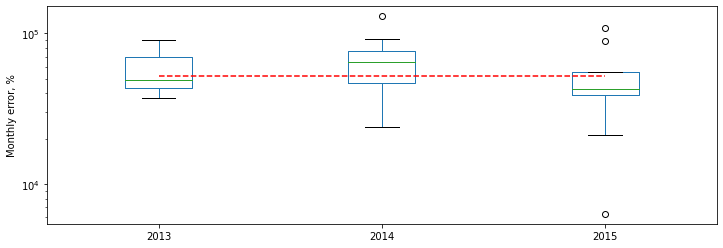

In [81]:
# Построим диаграммы размаха метрики MAE для тестовой выборки
Plots.boxplot(df_fc_prophet[-periods:], mae)

Среднее значение ежемесячной ошибки по годам: 0.9


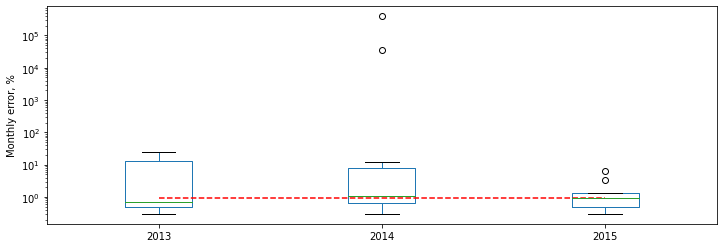

In [82]:
# Построим диаграммы размаха метрики MAPE для тестовой выборки
Plots.boxplot(df_fc_prophet[-periods:], mape)

### XGBoost


In [83]:
# Возьмем лаг в количестве 6 предыдущих значений
# Построим и обучим модель
lag = 6
train = series_to_supervised(df_train.to_list(), n_in=lag)
test = series_to_supervised(df_test.to_list(), n_in=lag)
X_train, y_train, X_test, y_test = train[:, :-1], train[:, -1], test[:, :-1], test[:, -1]
model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model_xgb.fit(X_train, y_train)


XGBRegressor(n_estimators=1000, objective='reg:squarederror')

(733773.0, 735964.0)

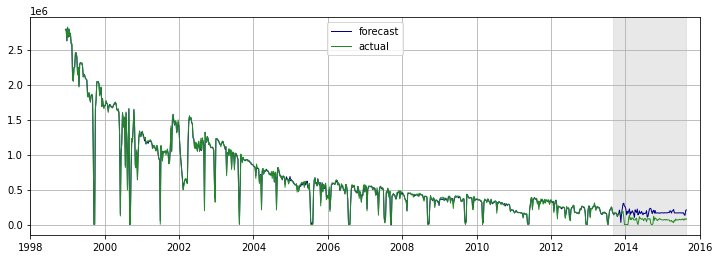

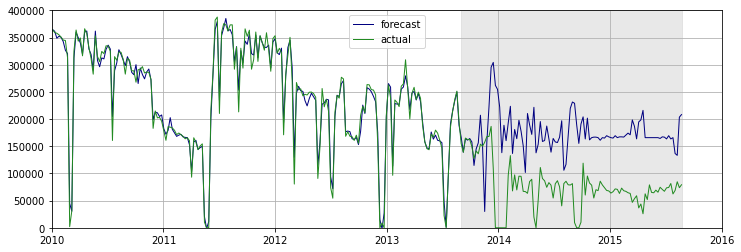

In [84]:
# Выделим истинные и прогнозные значения для графиков
actual = df['ALLOC_GAS_VOL_SM3'][lag:-lag]
forecast = pd.Series(model_xgb.predict(np.concatenate((X_train, X_test))))

# Дополним исходный датафрейм прогнозными значениями
df_fc_xgb = pd.concat([pd.Series(actual.index), pd.Series(actual.values), forecast],
                  axis=1, keys=['DAYTIME', 'actual', 'forecast']).set_index('DAYTIME')
df_fc_xgb.astype('float64')

# Построим график (полный)
Plots.forecast_plot(df_fc_xgb.actual, df_fc_xgb.forecast, predict_period)

# Построим график (по целевому участку)
Plots.forecast_plot(df_fc_xgb.actual, df_fc_xgb.forecast, predict_period)
plt.ylim(0, 4e05)
plt.xlim(pd.Timestamp(2010, 1, 1), pd.Timestamp(2016, 1, 1))


Среднее значение ежемесячной ошибки по годам: 10913.78


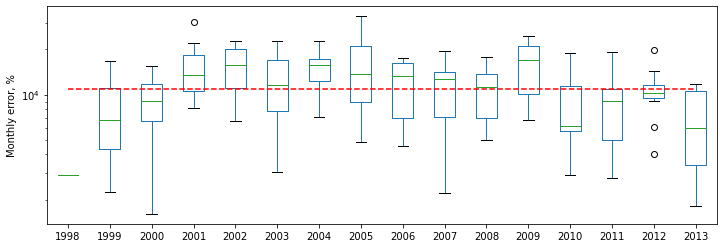

In [85]:
# Построим диаграммы размаха метрики MAE для обучающей выборки
Plots.boxplot(df_fc_xgb[:-X_test.shape[0]], mae)

Среднее значение ежемесячной ошибки по годам: 0.0


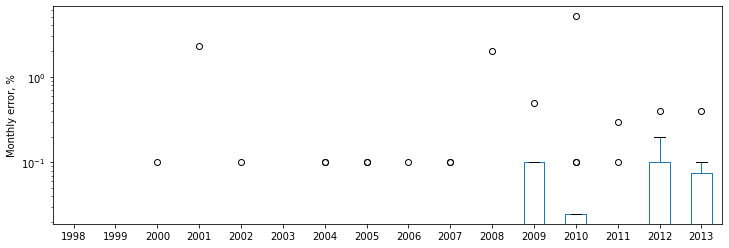

In [86]:
# Построим диаграммы размаха метрики MAPE для обучающей выборки
Plots.boxplot(df_fc_xgb[:-X_test.shape[0]], mape)

Среднее значение ежемесячной ошибки по годам: 80262.07


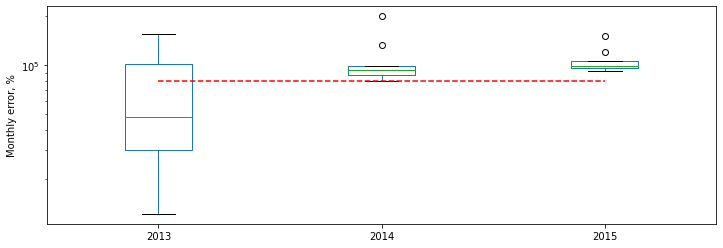

In [87]:
# Построим диаграммы размаха метрики MAE для тестовой выборки
Plots.boxplot(df_fc_xgb[-X_test.shape[0]:], mae)

Среднее значение ежемесячной ошибки по годам: 1.02


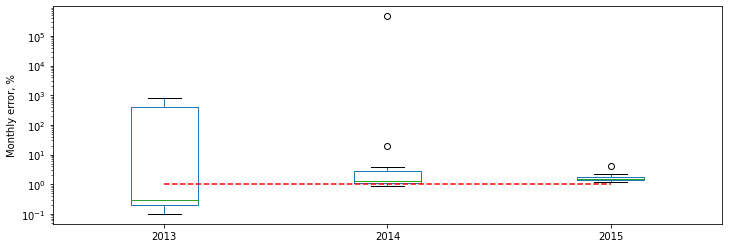

In [88]:
# Построим диаграммы размаха метрики MAPE для тестовой выборки
Plots.boxplot(df_fc_xgb[-X_test.shape[0]:], mape)

### Заключение

(729390.0, 735964.0)

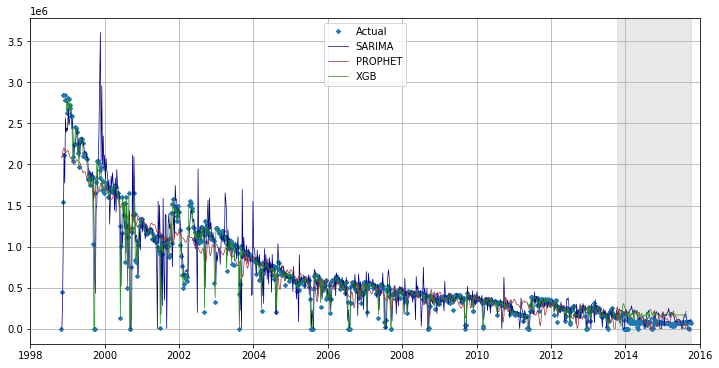

In [89]:
# Выведем общий график истинных и прогнозных значений всех моделей
Plots.results()
plt.xlim(pd.Timestamp(df_fc_arima.index[0].year, 1, 1), pd.Timestamp(df_fc_arima.index[-1].year+1, 1, 1))


(0.0, 700000.0)

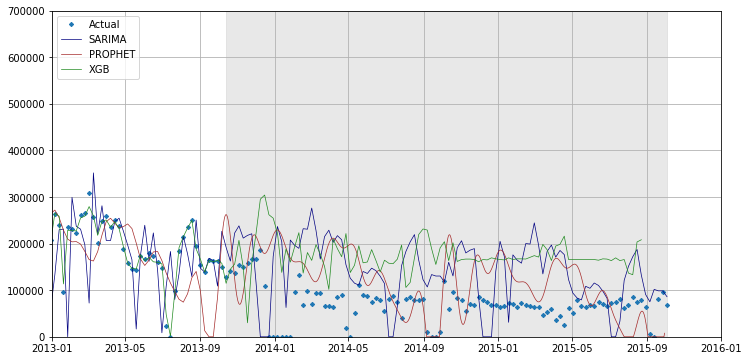

In [90]:
Plots.results()
plt.xlim(pd.Timestamp(df_fc_arima.index[-1].year-2, 1, 1), pd.Timestamp(df_fc_arima.index[-1].year+1, 1, 1))
plt.ylim(0, 7e05)


In [91]:
# Выведем сводную таблицу со значениями метрик качества всех моделей
pd.DataFrame({'Model': ['SARIMA', 'Facebook Prophet', 'XGBoost'],
              'MAE': [72585.07, 52159.27, 80262.07],
              'MAPE': [1.05, 0.9, 1.02]})


,Model,MAE,MAPE
0,SARIMA,72585.07,1.05
1,Facebook Prophet,52159.27,0.90
2,XGBoost,80262.07,1.02


Лучшее качество в решении задачи прогнозирования дебита газовой скважины 49/12а-К01 месторождения Viking в рамках данного исследования показала модель Facebook Prophet – МАЕ (тест) = 52159 $m^3$, МАРЕ (тест) = 0.90.